In [2]:
import nibabel as nib
import ast
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nilearn.image import new_img_like

from cmap import Colormap

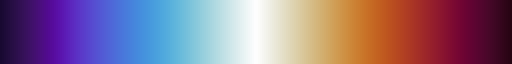

In [3]:


cm_div = Colormap('cmasher:fusion_r').to_matplotlib()
cm_div


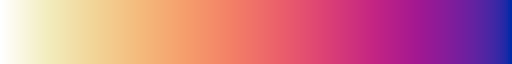

In [4]:
cm_div = Colormap('colorcet:cet_l17').to_matplotlib()
cm_div

In [5]:
from nilearn.datasets import (
    fetch_atlas_surf_destrieux,
    load_fsaverage,
    load_fsaverage_data,
)
from nilearn.surface import SurfaceImage

fsaverage = load_fsaverage("fsaverage5")
destrieux = fetch_atlas_surf_destrieux()
destrieux_atlas = SurfaceImage(
    mesh=fsaverage["pial"],
    data={
        "left": destrieux["map_left"],
        "right": destrieux["map_right"],
    },
)

# Retrieve fsaverage5 surface dataset for the plotting background.
# It contains the surface template as pial and inflated version.
fsaverage_meshes = load_fsaverage()

# The fsaverage meshes contains the FileMesh objects:
print(f"{fsaverage_meshes['pial'].parts['left']=}")
print(f"{fsaverage_meshes['inflated'].parts['left']=}")

# The fsaverage data contains file names pointing to the file locations
# The sulcal depth maps will be is used for shading.
fsaverage_sulcal = load_fsaverage_data(data_type="sulcal")
print(f"{fsaverage_sulcal=}")

[get_dataset_dir] Dataset found in /home/chris/nilearn_data/destrieux_surface
fsaverage_meshes['pial'].parts['left']=<FileMesh with 10242 vertices and 20480 faces.>
fsaverage_meshes['inflated'].parts['left']=<FileMesh with 10242 vertices and 20480 faces.>
fsaverage_sulcal=<SurfaceImage (20484,)>


[get_dataset_dir] Dataset found in /home/chris/nilearn_data/schaefer_2018


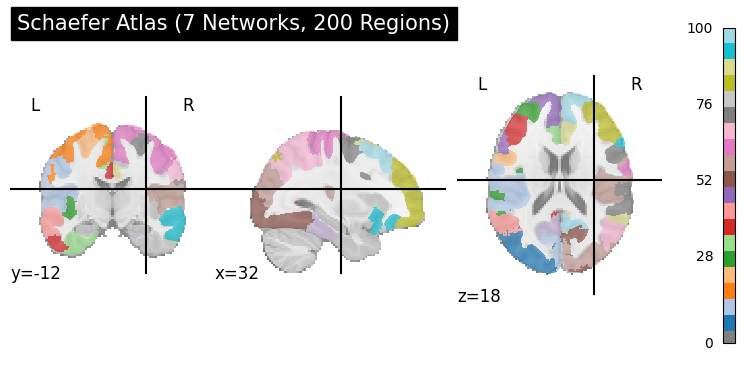

In [6]:
from nilearn import datasets, plotting
import numpy as np

# Step 1: Fetch the Schaefer Atlas
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)

# Step 2: Load atlas data
atlas_filename = schaefer_atlas['maps']
labels = schaefer_atlas['labels']

# Step 3: Create random colors for each region
n_regions = len(labels)
region_colors = np.linspace(0, 1, n_regions)  # Generate distinct values for colors

# Step 4: Plot the atlas with different colors per region
plotting.plot_roi(
    atlas_filename,
    title="Schaefer Atlas (7 Networks, 200 Regions)",
    display_mode='ortho',  # 'ortho', 'glass_brain', or 'mosaic' for different views
    colorbar=True,          # Show colorbar
    cmap='tab20',           # A colormap that supports discrete colors
)
plotting.show()


## Cat's code

In [7]:
def plot_brain_feature_importances(label='MMSE', head=20, method=None):
    atlas_path = '../figures/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz'  # Path to the atlas
    atlas_img = nib.load(atlas_path)
    atlas_data = atlas_img.get_fdata()

    # Load region label map from data/AD/Schaefer2018_200Parcels_7Networks_order_info.txt, each line is feature_name,region_label
    region_label_map = pd.read_csv('../figures/Schaefer2018_200Parcels_7Networks_order_info.txt')
    region_label_map = region_label_map.set_index('feature_name')['region_label']

    # Load feature importance
    df = pd.read_csv(f'../figures/processed/adni_feature_importances_{label}.csv')
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(head)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap=cm_div,
        vmin=-6.5, vmax=6.5,
        display_mode='lyrz',
    )

    plt.savefig(f'plots/adni_brain_fi_{label}.svg')
    # Show the plot
    plotting.show()

# Extract my data and convert to Cát's mapping

In [8]:
df_X_original = pd.read_pickle('../pickle/df_X_original.pickle')
df_X = pd.read_pickle('../pickle/df_X_filtered.pickle')
df_y =  pd.read_pickle('../pickle/df_y_original.pickle')
df_all = pd.read_pickle('../pickle/df_all_original.pickle')
select = pd.read_pickle('../pickle/select_features.pickle')

miss_mask = pd.read_pickle('../pickle/filter_miss_mask.pickle')
miss_mask = miss_mask.tolist()

df_X = df_X_original.drop(columns=[*select["MRIvol"], *select["PET"]])
df_X = df_X[miss_mask]

all(df_X.iloc[0, -200:].index == select["MRIth"])

FileNotFoundError: [Errno 2] No such file or directory: '../pickle/df_X_filtered.pickle'

In [ ]:
select["MRIth"] = [x.strip("_Cortical") for x in select["MRIth"]]

In [ ]:
local_matrix = pd.read_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_local_MRI.csv', names=["Importance"], header=None)
local_matrix.index = select["MRIth"]

In [ ]:
mmse_template = pd.read_csv('../figures/adni_feature_importances_MMSE.csv')
mmse_template.set_index("feature", inplace=True)

In [ ]:
local_matrix = local_matrix.reindex(index=mmse_template.index)


In [ ]:
atlas_path = '../figures/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz'  # Path to the atlas
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Load region label map from data/AD/Schaefer2018_200Parcels_7Networks_order_info.txt, each line is feature_name,region_label
region_label_map = pd.read_csv('../figures/Schaefer2018_200Parcels_7Networks_order_info.txt')
region_label_map = region_label_map.set_index('feature_name')['region_label']

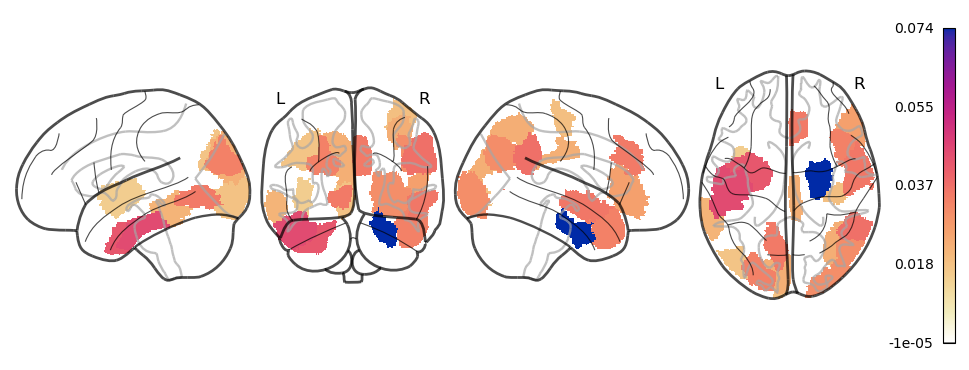

In [ ]:
df = local_matrix.reset_index(names="feature").rename(columns={"Importance":"importance"})

df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

# Map feature importance to brain regions
# Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
importance_map = np.zeros_like(atlas_data)

for _, row in df_sorted.iterrows():
    feature_name = row['feature']
    importance_value = row['abs_importance']

    # Extract the region index
    region_label = region_label_map.get(feature_name, None)

    # Map the importance value to the atlas region
    importance_map[atlas_data == region_label] = importance_value

# Create a new NIfTI image with the importance map
importance_img = new_img_like(atlas_img, importance_map)

# Plot the brain map using nilearn's plotting function
plotting.plot_glass_brain(
    importance_img,
    colorbar=True,
    cmap=cm_div,
    display_mode='lyrz',
)

plt.savefig(f'../figures/adni_brain_tabnet_local.png')
# Show the plot
plotting.show()

# Feature Importance on Test

### Permutation importance (Pearson scorer)

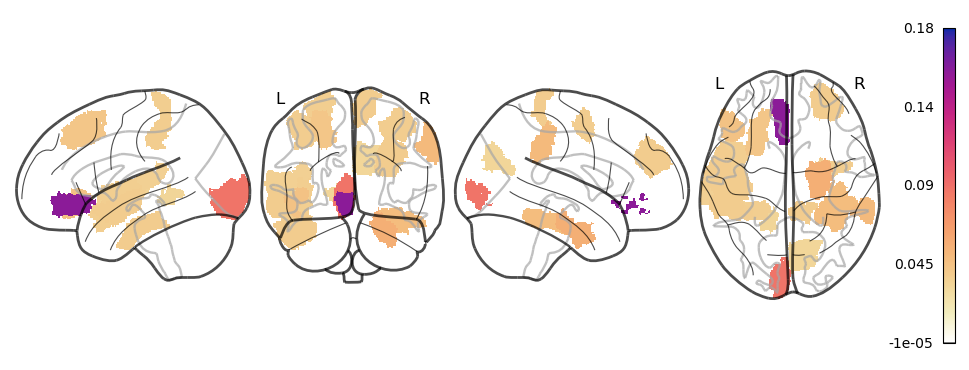

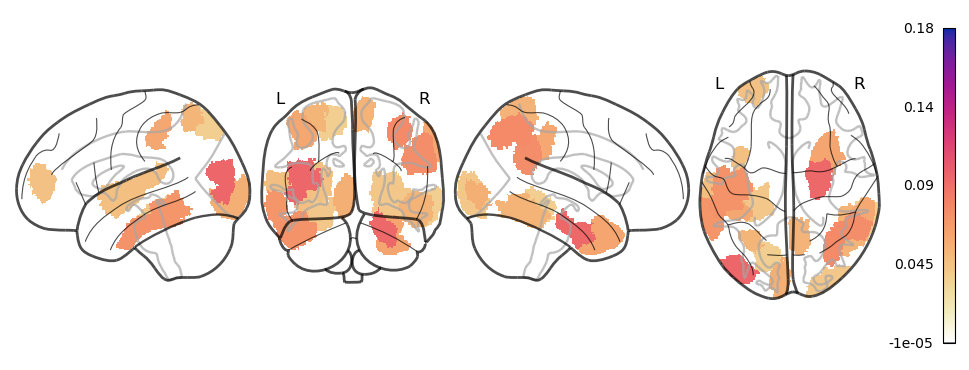

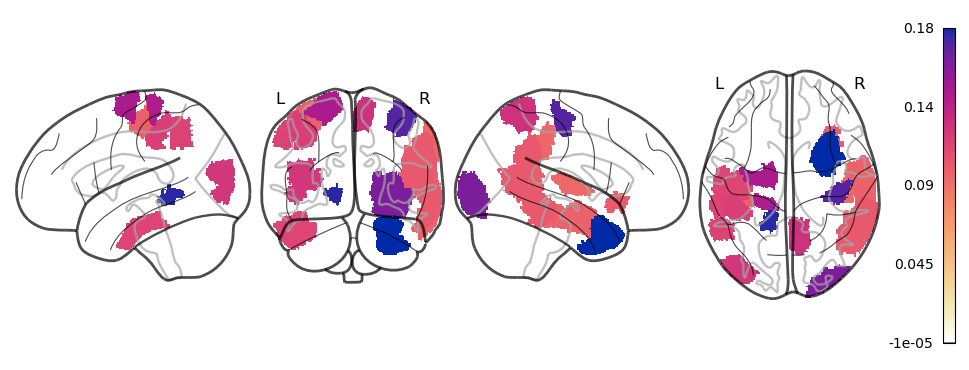

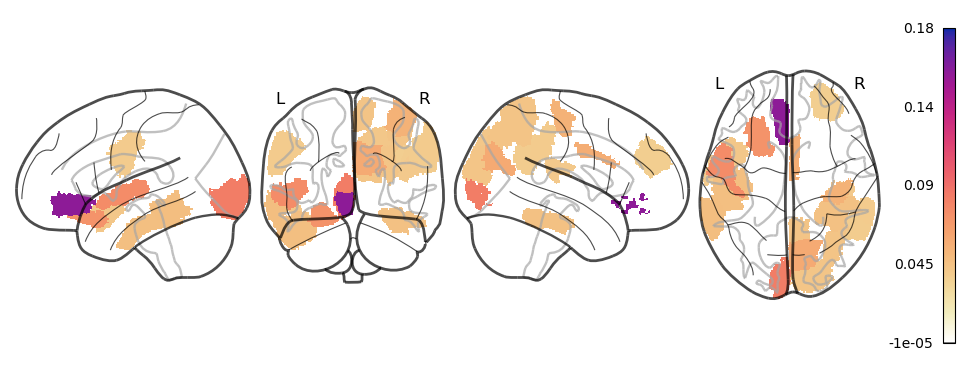

In [ ]:
permutation_matrix = pd.read_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_permutation_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
permutation_matrix.index = select["MRIth"]
permutation_matrix = permutation_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  permutation_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap=cm_div,
        display_mode='lyrz',
        vmin=0, 
        vmax=round(permutation_matrix.max().max(), 2)

    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Permutation importance (MAE scorer)

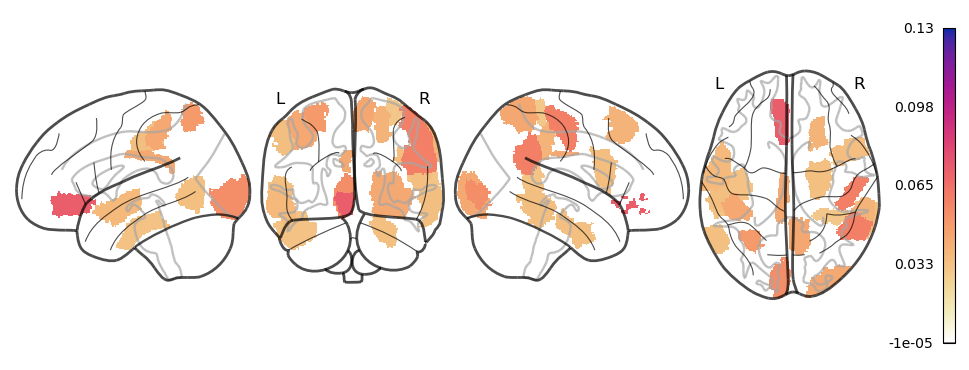

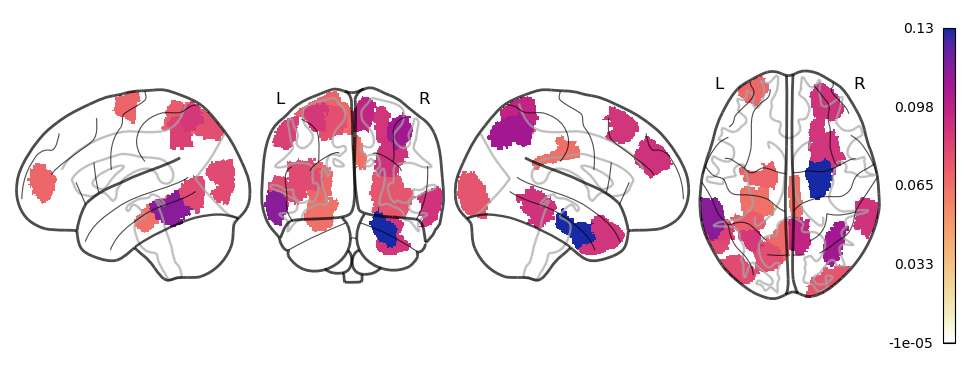

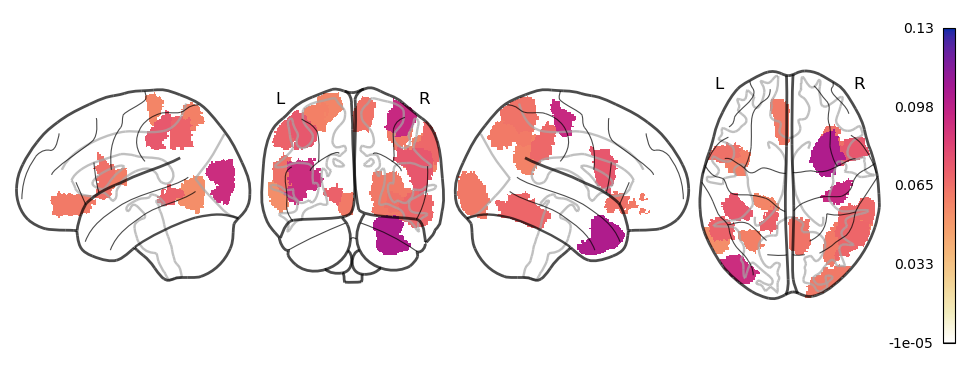

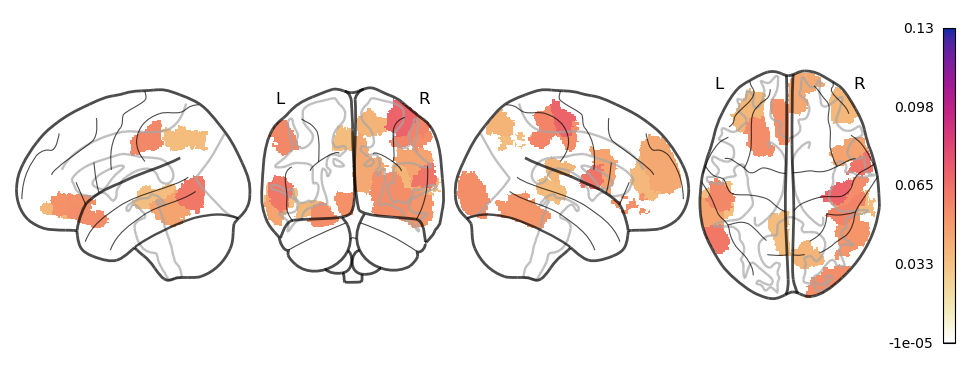

In [ ]:
perm_mae_matrix= pd.read_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_permutation_mae_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
perm_mae_matrix.index = select["MRIth"]
perm_mae_matrix = perm_mae_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  perm_mae_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap=cm_div,
        display_mode='lyrz',
        vmin=0,
        vmax=round(perm_mae_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_mae_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Shapley importance

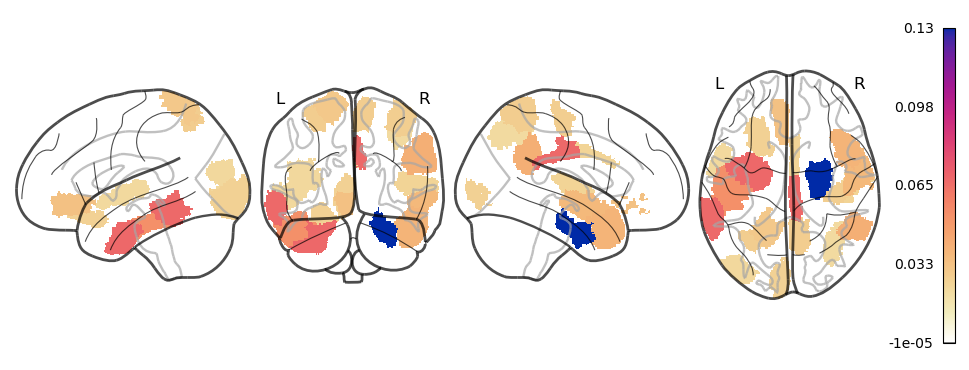

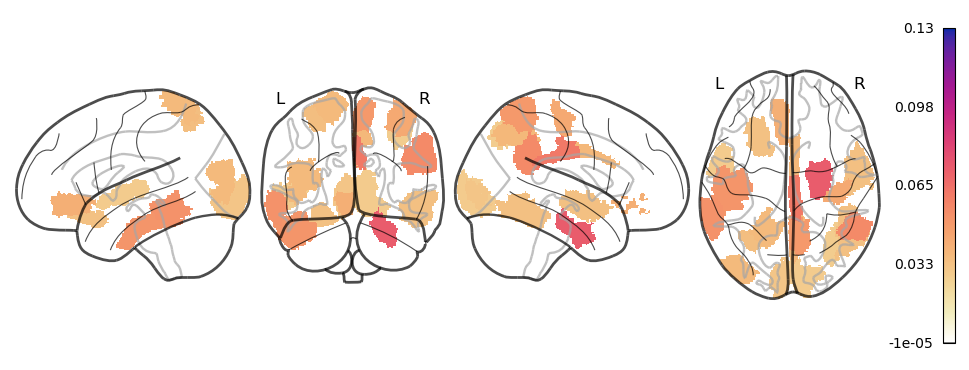

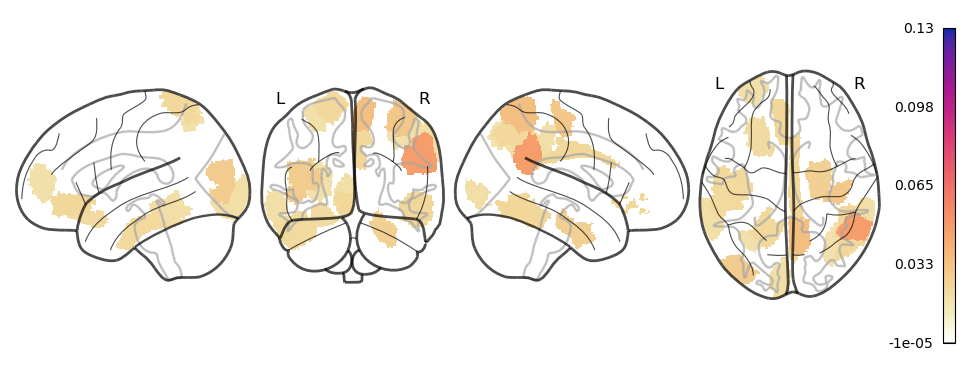

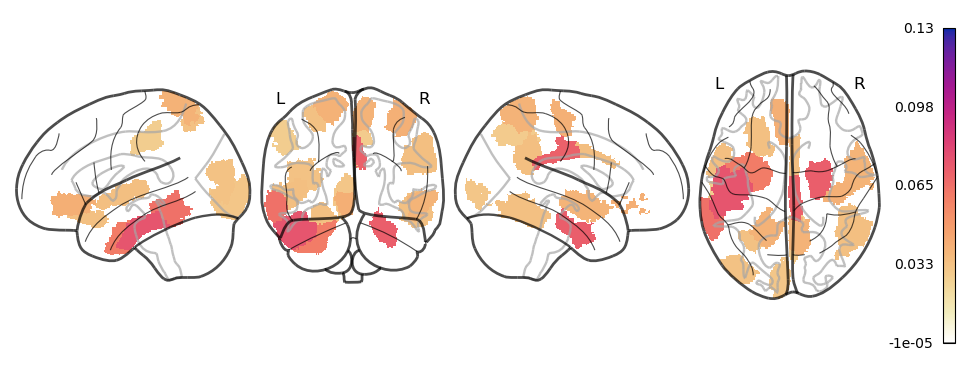

In [ ]:
shap_matrix= pd.read_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_shap_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
shap_matrix.index = select["MRIth"]
shap_matrix = shap_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  shap_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap=cm_div,
        display_mode='lyrz',
        vmin=0, 
        vmax=round(shap_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_shap_{target.lower()}.png')
    # Show the plot
    plotting.show()

# Feature importances values on Train

#### Shapley importance

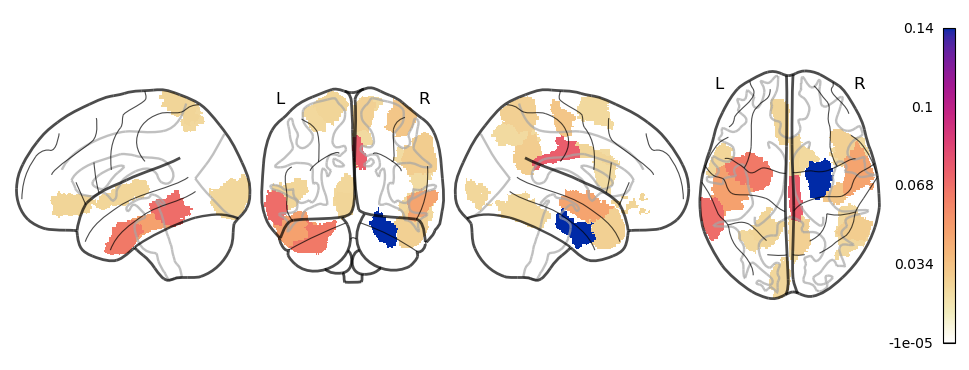

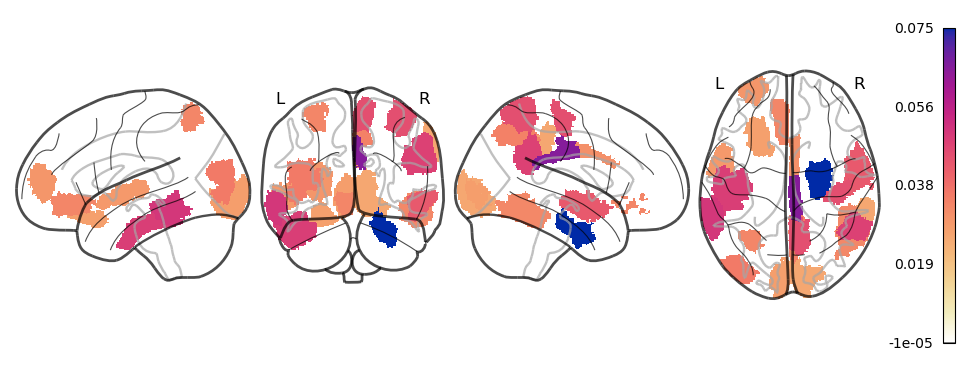

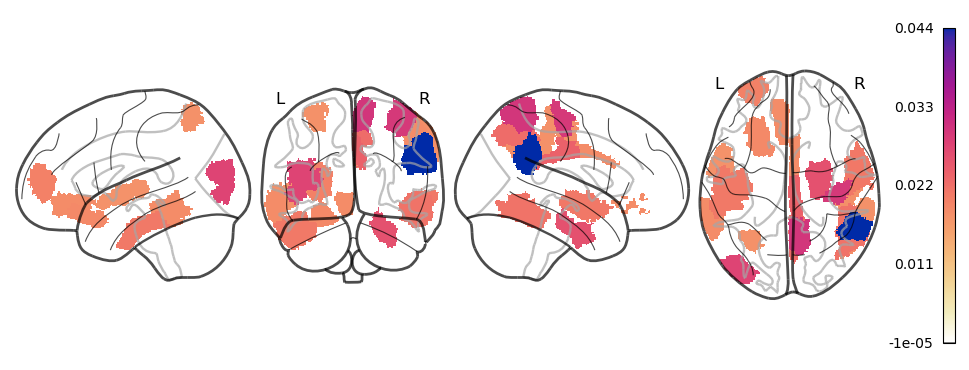

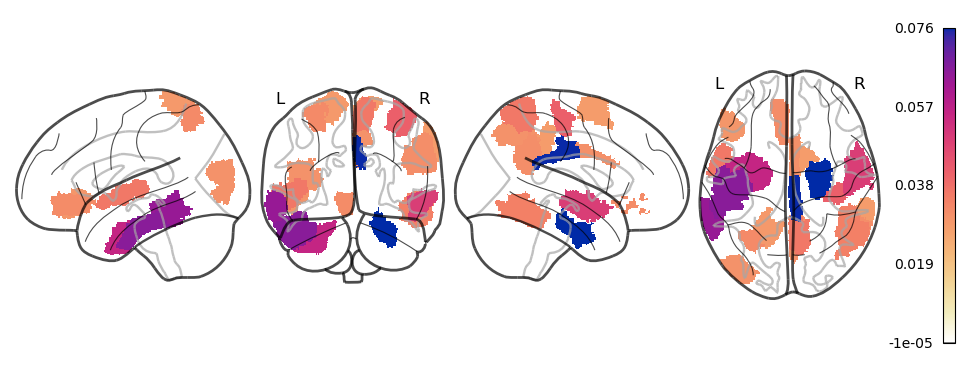

In [ ]:
shap_train_matrix= pd.read_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_shap_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
shap_train_matrix.index = select["MRIth"]
shap_train_matrix = shap_train_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  shap_train_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap=cm_div,
        display_mode='lyrz',
        vmin=0, 
        #vmax=round(shap_train_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_shap_train_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Permutation importance (Pearson scorer)

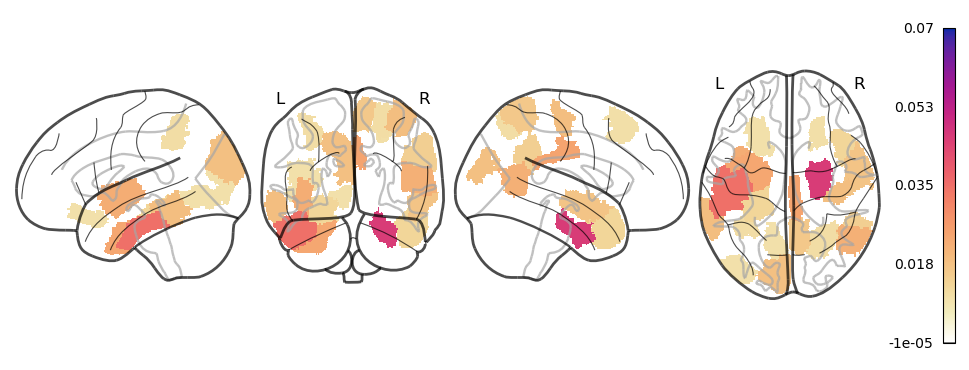

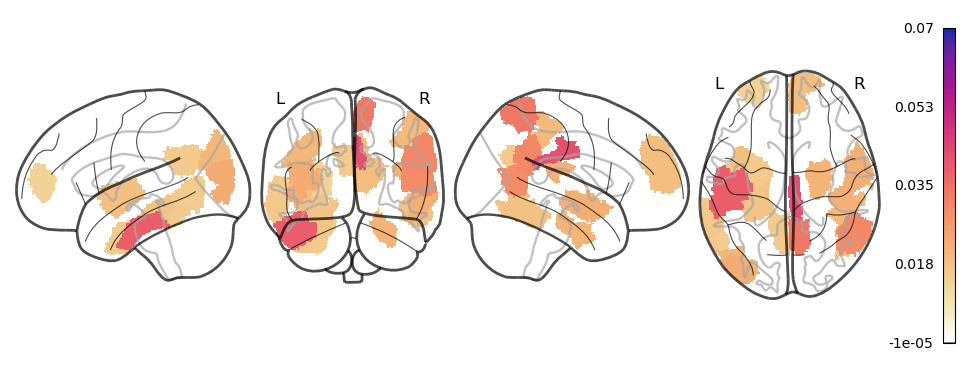

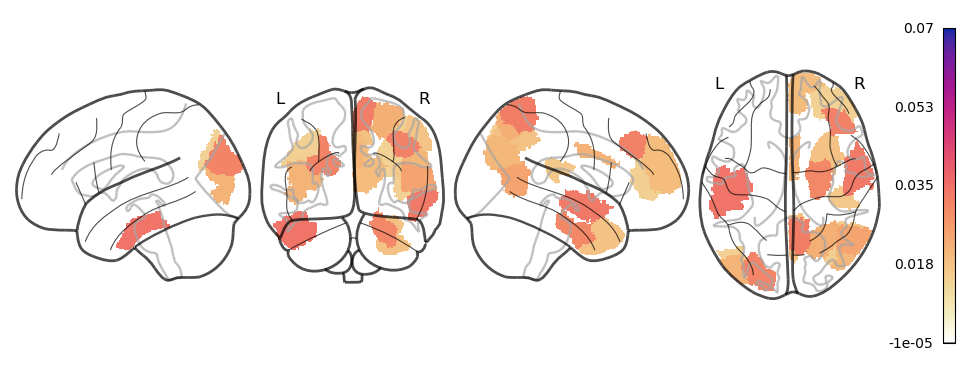

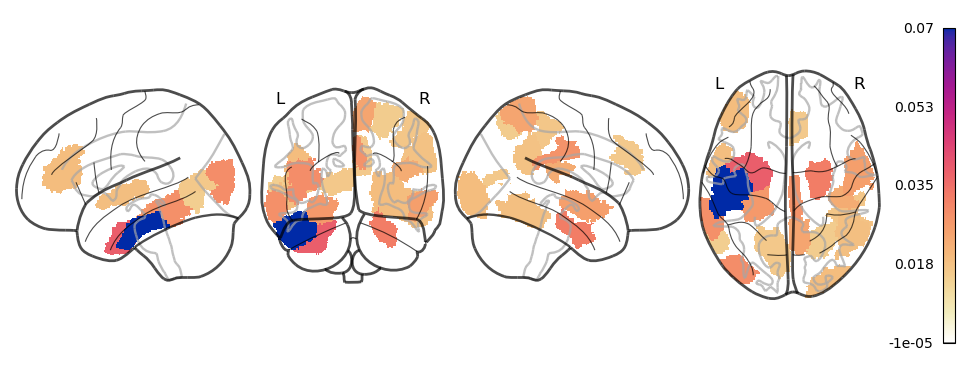

In [ ]:
perm_train_matrix= pd.read_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_permutation_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
perm_train_matrix.index = select["MRIth"]
perm_train_matrix = perm_train_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  perm_train_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap=cm_div,
        display_mode='lyrz',
        vmin=0,
        vmax=round(perm_train_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_train_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

#### Permutation importance (MAE scorer)

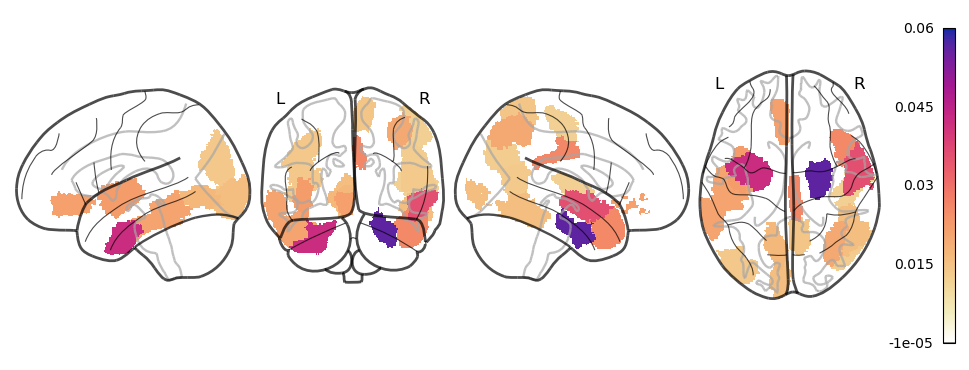

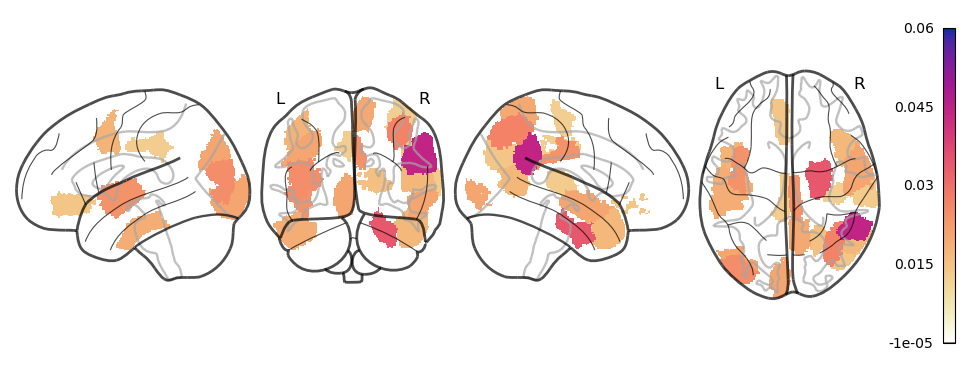

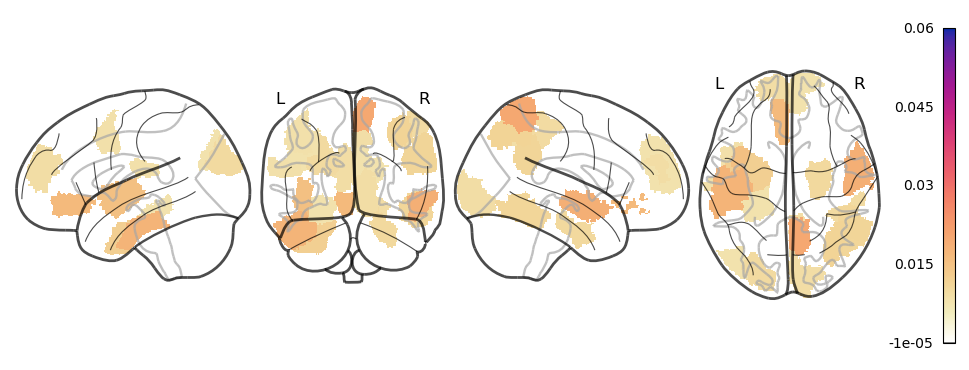

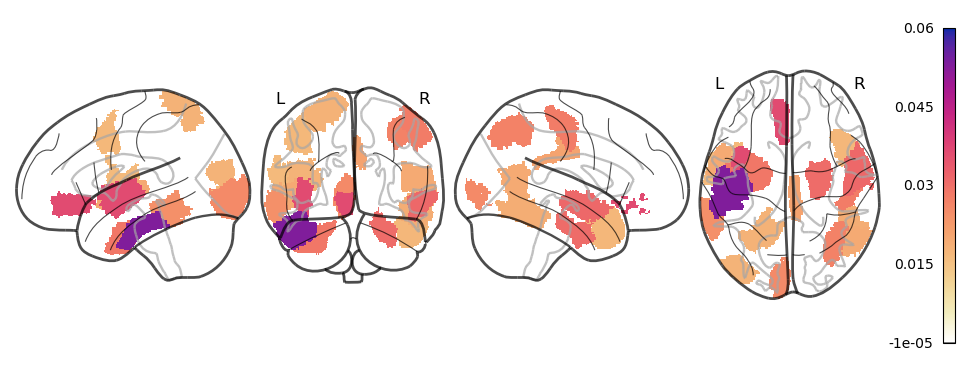

In [ ]:
perm_train_matrix= pd.read_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_permutation_mae_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
perm_train_matrix.index = select["MRIth"]
perm_train_matrix = perm_train_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  perm_train_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False).head(20)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['abs_importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap=cm_div,
        display_mode='lyrz',
        vmin=0,
        vmax=round(perm_train_matrix.max().max(), 2)
    )

    plt.savefig(f'../figures/adni_brain_tabnet_permutation_mae_train_matrix_{target.lower()}.png')
    # Show the plot
    plotting.show()

# Owen values

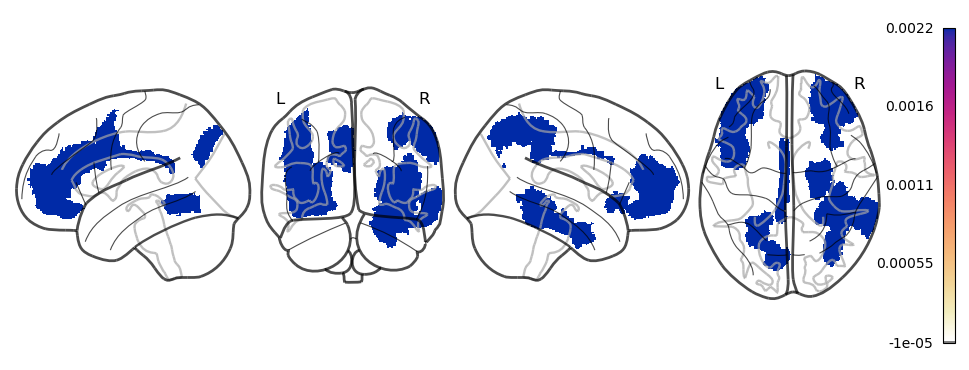

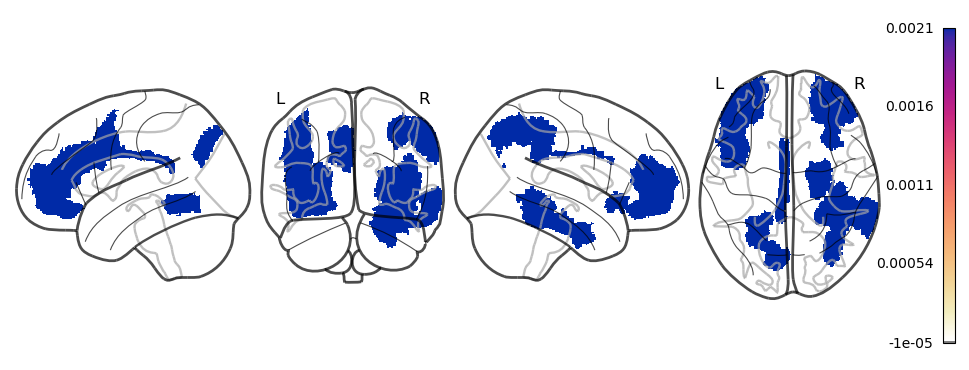

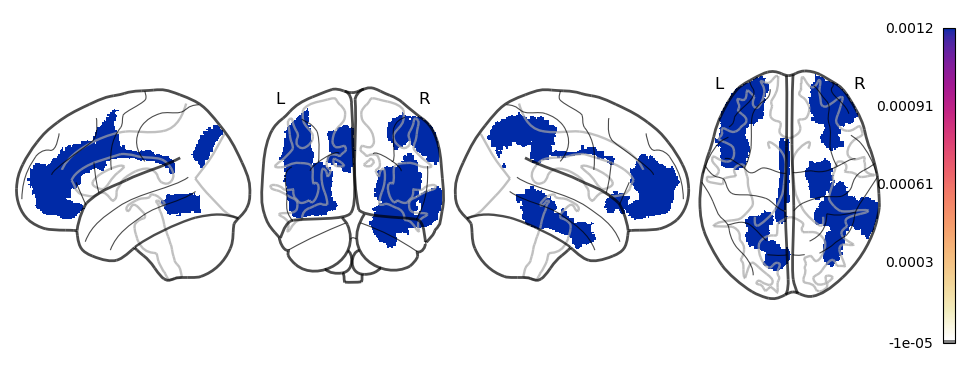

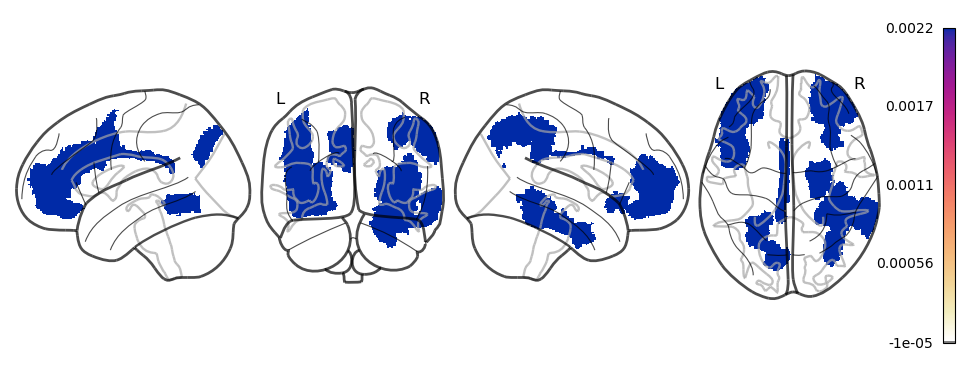

In [ ]:
owen_matrix= pd.read_csv('./6.1.2_missingnesss_aware_selection_pickle/TabNet_owen_train_MRI.csv', names=["Memory", "Executive Function", "Visuospatial", "Language"], header=None)
owen_matrix.index = select["MRIth"]
owen_matrix = owen_matrix.reindex(index=mmse_template.index)

for target in ["Memory", "Executive Function", "Visuospatial", "Language"]:
    df =  owen_matrix[target].reset_index().rename(columns={target:"importance"})
        
    df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
    df_sorted = df.sort_values(by='abs_importance', ascending=False)

    # Map feature importance to brain regions
    # Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
    importance_map = np.zeros_like(atlas_data)

    for _, row in df_sorted.iterrows():
        feature_name = row['feature']
        importance_value = row['importance']

        # Extract the region index
        region_label = region_label_map.get(feature_name, None)

        # Map the importance value to the atlas region
        importance_map[atlas_data == region_label] = importance_value

    # Create a new NIfTI image with the importance map
    importance_img = new_img_like(atlas_img, importance_map)

    # Plot the brain map using nilearn's plotting function
    plotting.plot_glass_brain(
        importance_img,
        colorbar=True,
        cmap=cm_div,
        display_mode='lyrz',
    )

    plt.savefig(f'../figures/adni_brain_tabnet_owen_{target.lower()}.png')
    # Show the plot
    plotting.show()

# Check input data and mapping

In [ ]:
df_X.iloc[:, -200:]

LH_Vis_1_Cortical  RH_Vis_1_Cortical  LH_Vis_2_Cortical  \
11             1.736904           2.500286           1.695385   
12             1.863712           2.455613           1.693945   
13             1.752436           2.444078           1.633198   
17             2.296219           2.802111           2.105479   
19             2.236341           2.741735           2.117744   
...                 ...                ...                ...   
9562           2.112685           2.501362           2.039709   
9573           2.214280           2.595687           2.150170   
9595           2.353381           2.546663           2.355751   
9611           2.364220           2.539578           2.329206   
9615           2.503605           2.695255           2.229275   

      RH_Vis_2_Cortical  LH_Vis_3_Cortical  RH_Vis_3_Cortical  \
11             2.025651           2.256913           1.893672   
12             2.022135           2.193292           1.906285   
13             1.881762           2.237461           1.868695   
17             2.186985           2.493885           2.188053   
19             2.196354           2.428991           2.151414   
...                 ...                ...                ...   
9562           2.192254           2.303997           2.075057   
9573           2.097128           2.329976           2.173061   
9595           2.119780           2.153600           2.106087   
9611           2.484561           2.487967           2.257653   
9615           2.247235           2.377845           2.253885   

      LH_Vis_4_Cortical  RH_Vis_4_Cortical  LH_Vis_5_Cortical  \
11             1.601304           1.804081           1.681952   
12             1.618809           1.824701           1.636593   
13             1.630254           1.759839           1.703541   
17             1.925127           2.074764           2.098069   
19             1.965349           1.952363           2.099488   
...                 ...                ...                ...   
9562           1.691713           1.934091           1.841811   
9573           2.134276           2.004636           2.181542   
9595           1.837774           1.958086           1.974831   
9611           2.128611           2.151779           2.152388   
9615           2.150890           2.177005           2.260058   

      RH_Vis_5_Cortical  ...  LH_Default_pCunPCC_1_Cortical  \
11             2.071637  ...                       2.044973   
12             2.081195  ...                       2.029172   
13             2.046701  ...                       1.967125   
17             2.400943  ...                       2.444347   
19             2.377010  ...                       2.347611   
...                 ...  ...                            ...   
9562           2.332017  ...                       2.713503   
9573           2.151484  ...                       2.389298   
9595           2.319513  ...                       2.745870   
9611           2.193423  ...                       2.610942   
9615           2.294938  ...                       2.662697   

      RH_Default_PFCdPFCm_6_Cortical  LH_Default_pCunPCC_2_Cortical  \
11                          2.225490                       2.155638   
12                          2.217474                       2.108788   
13                          2.216598                       2.068816   
17                          2.619748                       2.582679   
19                          2.499187                       2.535837   
...                              ...                            ...   
9562                        2.051879                       2.522892   
9573                        2.060905                       2.413770   
9595                        2.226410                       2.635547   
9611                        2.342472                       2.678210   
9615                        2.269210                       2.659877   

      RH_Default_PFCdPFCm_7_Cortical  LH_Default_pCun

In [ ]:
df_all = pd.read_csv("../../../dataset/ADNI/ALL_3.csv").replace({"sc":"bl","Female":0, "Male":1})

/tmp/ipykernel_56829/3839394820.py:1: DtypeWarning: Columns (27,111) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv("../../../dataset/ADNI/ALL_3.csv").replace({"sc":"bl","Female":0, "Male":1})


In [ ]:
df_plot = df_all.dropna(subset=["Schaefer_200_7"])

In [ ]:
df_plot.DX

3        CN
4        AD
5       MCI
6       MCI
7       MCI
       ... 
7200    MCI
7201    MCI
7202     CN
7214     CN
7217    MCI
Name: DX, Length: 2899, dtype: object

In [ ]:
n = 7214

In [ ]:
to_plot = ast.literal_eval(df_plot["Schaefer_200_7"][n])

to_plot = df_X.iloc[0, -200:].to_list()

In [ ]:
df_X.iloc[0, -200:].index.to_list()

['LH_Vis_1_Cortical',
 'RH_Vis_1_Cortical',
 'LH_Vis_2_Cortical',
 'RH_Vis_2_Cortical',
 'LH_Vis_3_Cortical',
 'RH_Vis_3_Cortical',
 'LH_Vis_4_Cortical',
 'RH_Vis_4_Cortical',
 'LH_Vis_5_Cortical',
 'RH_Vis_5_Cortical',
 'LH_Vis_6_Cortical',
 'RH_Vis_6_Cortical',
 'LH_Vis_7_Cortical',
 'RH_Vis_7_Cortical',
 'LH_Vis_8_Cortical',
 'RH_Vis_8_Cortical',
 'LH_Vis_9_Cortical',
 'RH_Vis_9_Cortical',
 'LH_Vis_10_Cortical',
 'RH_Vis_10_Cortical',
 'LH_Vis_11_Cortical',
 'RH_Vis_11_Cortical',
 'LH_Vis_12_Cortical',
 'RH_Vis_12_Cortical',
 'LH_Vis_13_Cortical',
 'RH_Vis_13_Cortical',
 'LH_Vis_14_Cortical',
 'RH_Vis_14_Cortical',
 'LH_SomMot_1_Cortical',
 'RH_Vis_15_Cortical',
 'LH_SomMot_2_Cortical',
 'RH_SomMot_1_Cortical',
 'LH_SomMot_3_Cortical',
 'RH_SomMot_2_Cortical',
 'LH_SomMot_4_Cortical',
 'RH_SomMot_3_Cortical',
 'LH_SomMot_5_Cortical',
 'RH_SomMot_4_Cortical',
 'LH_SomMot_6_Cortical',
 'RH_SomMot_5_Cortical',
 'LH_SomMot_7_Cortical',
 'RH_SomMot_6_Cortical',
 'LH_SomMot_8_Cortical',
 

In [ ]:
def csv_to_list(filename):
    lst = pd.read_csv(filename, header=None)
    return lst[0].values.tolist()

def read_featurenames(remove_medial_wall=True):
        r_featurename="../../../dataset/ADNI/rh_mapping_names.csv"
        l_featurename="../../../dataset/ADNI/lh_mapping_names.csv"
        
        r_features = csv_to_list(r_featurename)
        l_features = csv_to_list(l_featurename)

        all_features = [None]*(len(l_features)+len(r_features))

        if remove_medial_wall: 
            all_features[::2] = l_features
            all_features[1::2] = r_features
            all_features = all_features[2:]

        all_features = list(map(lambda s : s.replace("7Networks_", ""), all_features))

        return all_features

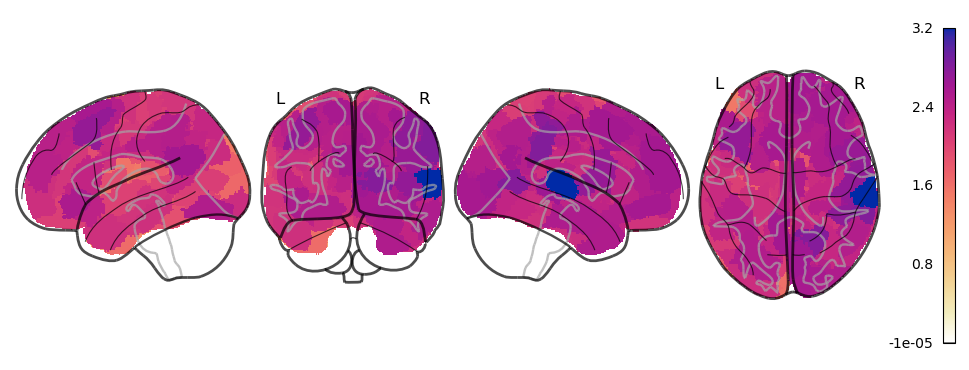

In [ ]:
df = pd.DataFrame(to_plot, index=region_label_map.index, columns=["importance"]).reset_index(names=["feature"])

df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
df_sorted = df.sort_values(by='abs_importance', ascending=False)

# Map feature importance to brain regions
# Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
importance_map = np.zeros_like(atlas_data)

for _, row in df_sorted.iterrows():
    feature_name = row['feature']
    importance_value = row['importance']

    # Extract the region index
    region_label = region_label_map.get(feature_name, None)

    # Map the importance value to the atlas region
    importance_map[atlas_data == region_label] = importance_value

# Create a new NIfTI image with the importance map
importance_img = new_img_like(atlas_img, importance_map)

# Plot the brain map using nilearn's plotting function
plotting.plot_glass_brain(
    importance_img,
    colorbar=True,
    cmap=cm_div,
    display_mode='lyrz',
)

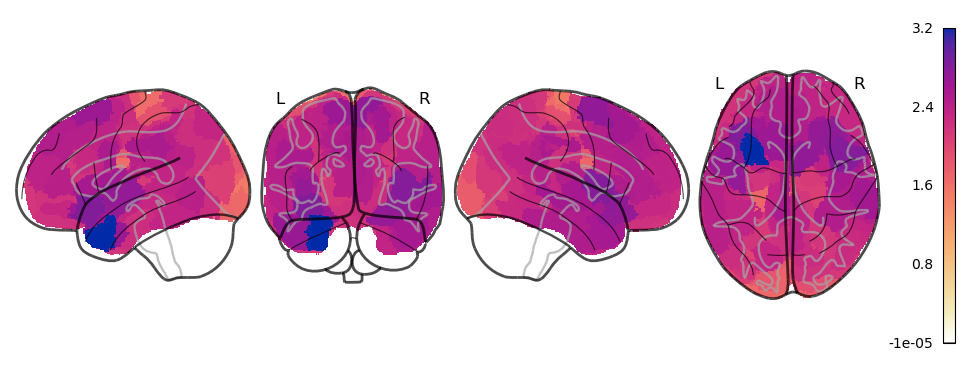

In [ ]:
df = pd.DataFrame(to_plot, index=select["MRIth"], columns=["importance"]).reset_index(names=["feature"])

df["feature"] = df["feature"].apply(lambda x : x.replace("_Cortical", ""))

df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
df_sorted = df.sort_values(by='abs_importance', ascending=False)

# Map feature importance to brain regions
# Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
importance_map = np.zeros_like(atlas_data)

for _, row in df_sorted.iterrows():
    feature_name = row['feature']
    importance_value = row['importance']

    # Extract the region index
    region_label = region_label_map.get(feature_name, None)

    # Map the importance value to the atlas region
    importance_map[atlas_data == region_label] = importance_value

# Create a new NIfTI image with the importance map
importance_img = new_img_like(atlas_img, importance_map)

# Plot the brain map using nilearn's plotting function
plotting.plot_glass_brain(
    importance_img,
    colorbar=True,
    cmap=cm_div,
    display_mode='lyrz',
)

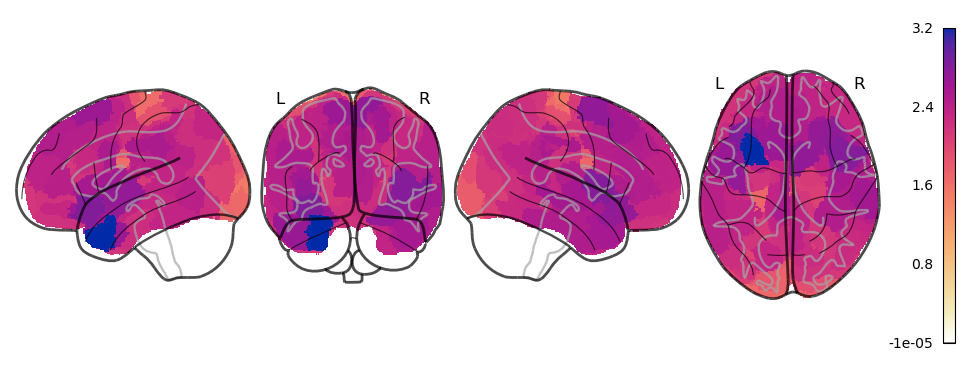

In [ ]:
df = pd.DataFrame(to_plot, index=df_X.iloc[0, -200:].index.to_list(), columns=["importance"]).reset_index(names=["feature"])

df["feature"] = df["feature"].apply(lambda x : x.replace("_Cortical", ""))

df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
df_sorted = df.sort_values(by='abs_importance', ascending=False)

# Map feature importance to brain regions
# Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
importance_map = np.zeros_like(atlas_data)

for _, row in df_sorted.iterrows():
    feature_name = row['feature']
    importance_value = row['importance']

    # Extract the region index
    region_label = region_label_map.get(feature_name, None)

    # Map the importance value to the atlas region
    importance_map[atlas_data == region_label] = importance_value

# Create a new NIfTI image with the importance map
importance_img = new_img_like(atlas_img, importance_map)

# Plot the brain map using nilearn's plotting function
plotting.plot_glass_brain(
    importance_img,
    colorbar=True,
    cmap=cm_div,
    display_mode='lyrz',
)

In [ ]:
def csv_to_list(filename):
    lst = pd.read_csv(filename, header=None)
    return lst[0].values.tolist()

def read_featurenames(remove_medial_wall=True):
        r_featurename="../../../dataset/ADNI/rh_mapping_names.csv"
        l_featurename="../../../dataset/ADNI/lh_mapping_names.csv"
        
        r_features = csv_to_list(r_featurename)
        l_features = csv_to_list(l_featurename)

        all_features = [None]*(len(l_features)+len(r_features))

        if remove_medial_wall: 
            all_features[::2] = l_features
            all_features[1::2] = r_features
            all_features = all_features[2:]

        all_features = list(map(lambda s : s.replace("7Networks_", ""), all_features))

        return all_features

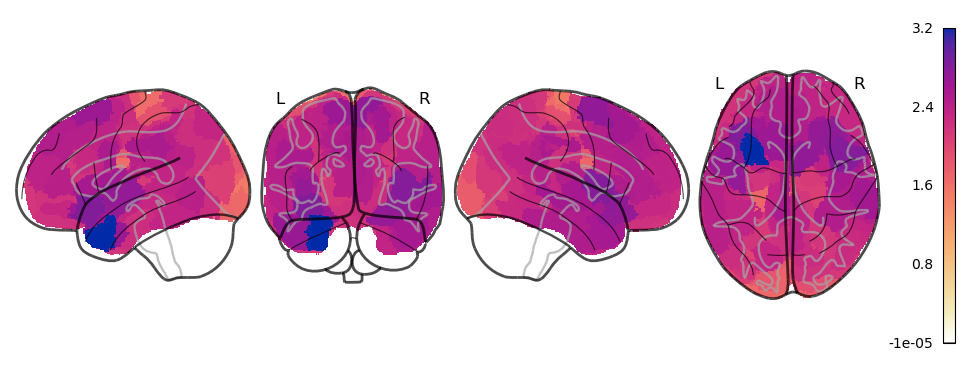

In [ ]:
df = pd.DataFrame(to_plot, index=read_featurenames(remove_medial_wall=True), columns=["importance"]).reset_index(names=["feature"])

df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
df_sorted = df.sort_values(by='abs_importance', ascending=False)

# Map feature importance to brain regions
# Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
importance_map = np.zeros_like(atlas_data)

for _, row in df_sorted.iterrows():
    feature_name = row['feature']
    importance_value = row['importance']

    # Extract the region index
    region_label = region_label_map.get(feature_name, None)

    # Map the importance value to the atlas region
    importance_map[atlas_data == region_label] = importance_value

# Create a new NIfTI image with the importance map
importance_img = new_img_like(atlas_img, importance_map)

# Plot the brain map using nilearn's plotting function
plotting.plot_glass_brain(
    importance_img,
    colorbar=True,
    cmap=cm_div,
    display_mode='lyrz',
)

In [ ]:
def csv_to_list(filename):
    lst = pd.read_csv(filename, header=None)
    return lst[0].values.tolist()

def read_featurenames(remove_medial_wall=True):
    r_featurename="../../../dataset/ADNI/rh_mapping_names.csv"
    l_featurename="../../../dataset/ADNI/lh_mapping_names.csv"
    
    r_features = csv_to_list(r_featurename)
    l_features = csv_to_list(l_featurename)

    all_features = [None]*(len(l_features)+len(r_features))

    if remove_medial_wall: 
        all_features[::2] = r_features
        all_features[1::2] = l_features
        all_features = all_features[2:]

    all_features = list(map(lambda s : s.replace("7Networks_", ""), all_features))

    return all_features

In [ ]:
df = pd.DataFrame(to_plot, index=read_featurenames(remove_medial_wall=True), columns=["importance"]).reset_index(names=["feature"])

df['abs_importance'] = df['importance'].abs()  # Use absolute importance for ranking
df_sorted = df.sort_values(by='abs_importance', ascending=False)

# Map feature importance to brain regions
# Assuming the atlas regions are labeled as integers (LH and RH have different IDs)
importance_map = np.zeros_like(atlas_data)

for _, row in df_sorted.iterrows():
    feature_name = row['feature']
    importance_value = row['importance']

    # Extract the region index
    region_label = region_label_map.get(feature_name, None)

    # Map the importance value to the atlas region
    importance_map[atlas_data == region_label] = importance_value

# Create a new NIfTI image with the importance map
importance_img = new_img_like(atlas_img, importance_map)

# Plot the brain map using nilearn's plotting function
plotting.plot_glass_brain(
    importance_img,
    colorbar=True,
    cmap=cm_div,
    display_mode='lyrz',
    colorbar=True
)

SyntaxError: keyword argument repeated: colorbar (3626808581.py, line 29)

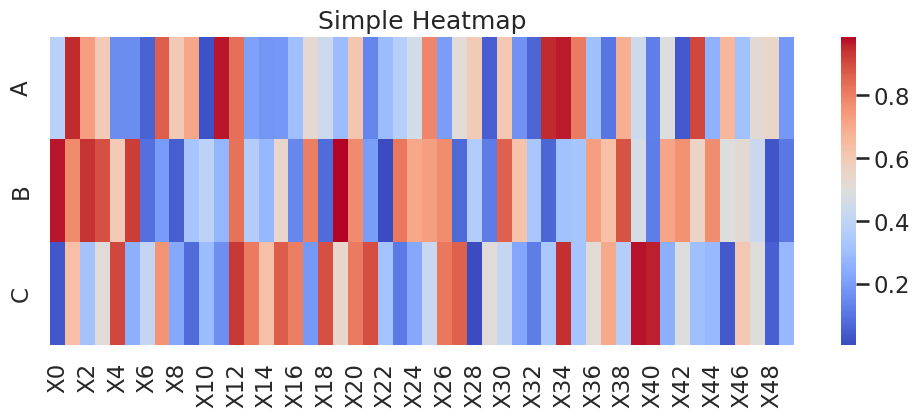

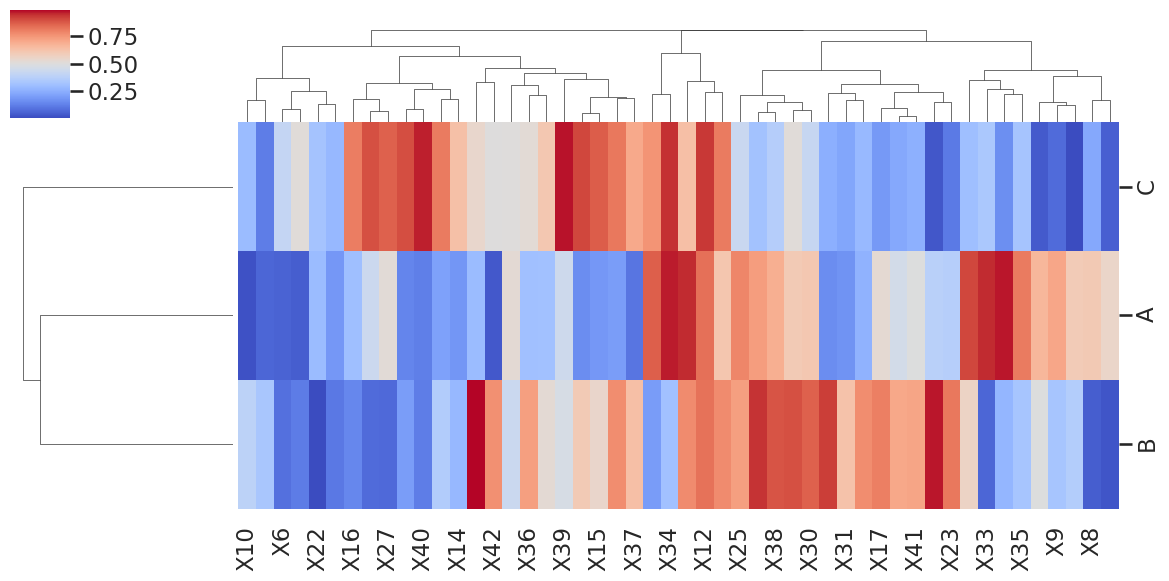

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set_style("white")
sns.set_context("talk")

# Generate sample data
np.random.seed(42)  # For reproducibility
data = np.random.rand(3, 50)  # 3 rows, 50 columns
df = pd.DataFrame(data, index=["A", "B", "C"], columns=[f"X{i}" for i in range(50)])

# Create a heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(df, cmap="coolwarm", annot=False, cbar=True)
plt.title("Simple Heatmap")
plt.show()

# Create a clustermap
g = sns.clustermap(df, figsize=(12, 6), cmap="coolwarm", method="average")
plt.show()


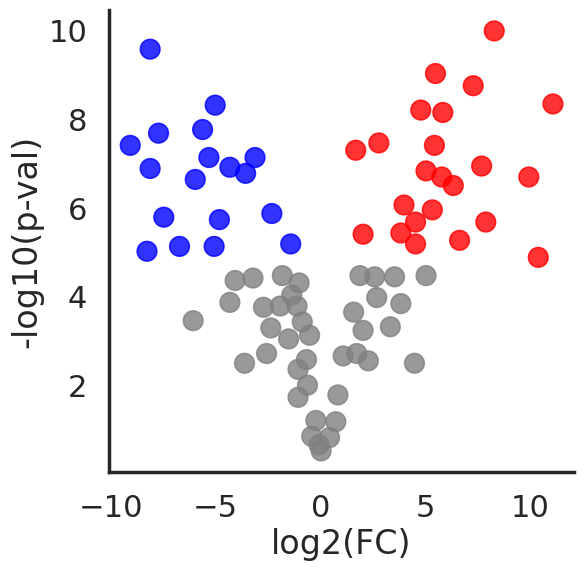

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# New data points
data = np.array([
    [10.025, 0.95, 4], [8.975, 7.85, 4], [11.875, 8.15, 4], [8.175, 8.15, 4], 
    [6.775, 8.05, 4], [5.925, 7.95, 4], [12.575, 8.1, 4], [13.525, 8.1, 4], 
    [15.025, 8.15, 4], [8.625, 7.35, 4], [9.125, 6.25, 4], [8.875, 6.9, 4], 
    [8.475, 5.55, 4], [9.325, 4.7, 4], [9.375, 3.65, 4], [9.775, 2.2, 4], 
    [9.925, 1.2, 4], [9.575, 1.55, 4], [10.425, 1.5, 4], [10.725, 2.15, 4], 
    [10.825, 3.25, 4], [11.075, 4.85, 4], [11.575, 6.65, 4], [11.725, 4.95, 4], 
    [12.025, 5.9, 4], [13.325, 6.05, 4], [12.675, 7.25, 4], [13.825, 7, 4], 
    [12.275, 4.65, 4], [8.075, 6.9, 4], [7.275, 6.85, 4], [3.925, 6.3, 4], 
    [5.675, 7.05, 4], [7.625, 6, 4], [8.925, 3.15, 4], [8.925, 4.3, 4], 
    [9.475, 5.7, 4], [7.425, 4.95, 4], [6.375, 4.55, 4], [14.475, 4.55, 4], 
    [1.725, 9.15, 3], [3.275, 9.35, 3], [4.925, 9.35, 3], [7.675, 10.7, 3], 
    [8.575, 9.45, 3], [6.875, 13, 3], [4.975, 15.15, 3], [2.275, 14, 3], 
    [1.875, 12.55, 3], [2.525, 10.55, 3], [5.175, 10.45, 3], [4.675, 13, 3], 
    [5.675, 12.6, 3], [4.375, 14.15, 3], [4.025, 12.1, 3], [1.875, 17.45, 3], 
    [0.925, 13.5, 3], [6.425, 12.35, 3], [12.025, 9.85, 1], [11.675, 13.3, 1], 
    [14.775, 14.95, 1], [17.275, 15.95, 1], [17.675, 12.65, 1], [17.875, 10.35, 1], 
    [16.625, 9.6, 1], [21.075, 15.2, 1], [18.275, 18.2, 1], [14.525, 9.45, 1], 
    [13.825, 9.9, 1], [13.975, 11.05, 1], [15.325, 10.85, 1], [15.825, 14.85, 1], 
    [15.425, 13.5, 1], [12.775, 13.6, 1], [19.925, 12.2, 1], [20.375, 8.9, 1], 
    [15.475, 16.45, 1], [15.025, 12.45, 1], [15.775, 12.2, 1], [16.325, 11.85, 1], 
    [14.525, 10.35, 1]
])

# Shift log2FC: Set x=10 to 0
data[:, 0] -= 10  # Shift x-axis

# Scale -log10(p-value) between 0 and 10
max_y = np.max(data[:, 1])
data[:, 1] = (data[:, 1] / max_y) * 10  # Normalize y-axis

# Convert to DataFrame
df = pd.DataFrame(data, columns=["log2FC", "-log10(p-val)", "Class"])

# Map class labels to colors
color_mapping = {1: "red", 3: "blue", 4: "grey"}
df["Color"] = df["Class"].map(color_mapping)

# Set Seaborn style
sns.set_style("white")
sns.set_context("poster")

# Plot
plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x="log2FC", y="-log10(p-val)", hue="Color",
                palette={"blue": "blue", "red": "red", "grey": "grey"},
                alpha=0.8, edgecolor=None, s=200, legend=False)  # Bigger points, no legend

# Labels
plt.xlabel("log2(FC)")
plt.ylabel("-log10(p-val)")

# Remove title
plt.title("")

sns.despine()
plt.show()


/tmp/ipykernel_689121/345905427.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="x", y="y", palette=colors, s=200, edgecolor=None, linewidth=1.2, legend=False)


<Figure size 640x480 with 0 Axes>

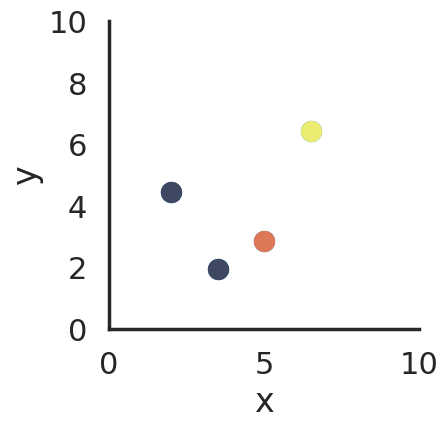

/tmp/ipykernel_689121/345905427.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="x", y="y", palette=colors, s=200, edgecolor=None, linewidth=1.2, legend=False)


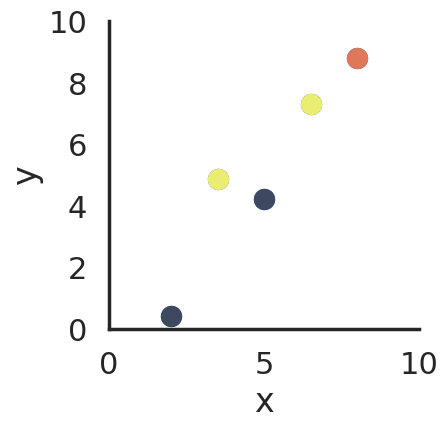

/tmp/ipykernel_689121/345905427.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="x", y="y", palette=colors, s=200, edgecolor=None, linewidth=1.2, legend=False)


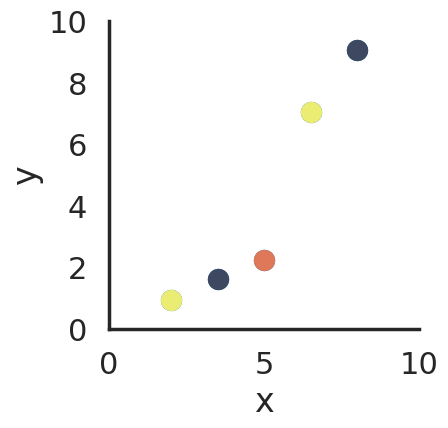

/tmp/ipykernel_689121/345905427.py:32: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df, x="x", y="y", palette=colors, s=200, edgecolor=None, linewidth=1.2, legend=False)


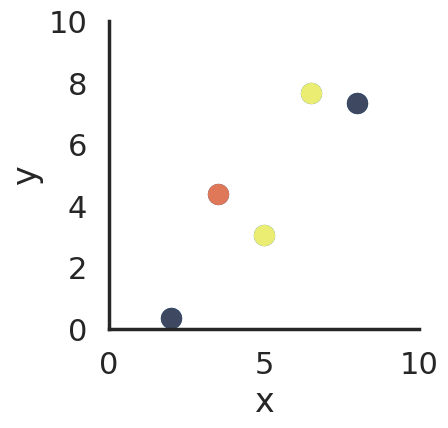

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set style
sns.set_style("white")
sns.set_context("poster")
sns.despine()

# Colors (hexadecimal)
colors = ["#3f4861", "#3f4861", "#ebed72", "#ebed72", "#de7859"]

# Generate 4 separate plots
for i in range(4):
    plt.figure(figsize=(4, 4))  # Create a new figure

    # Generate 5 points near y = x with more noise
    x = np.linspace(2, 8, 5)
    y = x + np.random.uniform(-3, 3, 5)  # Add more noise

    # Shuffle colors
    np.random.shuffle(colors)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame({"x": x, "y": y})

    # Plot regression line following y = x
    #sns.lineplot(x=x, y=x, color="grey", linestyle="dashed", linewidth=1.5)

    # Scatter plot with Seaborn, manually set the color for each point
    sns.scatterplot(data=df, x="x", y="y", palette=colors, s=200, edgecolor=None, linewidth=1.2, legend=False)

    # Set color manually using the 'color' column in the dataframe
    for j, color in enumerate(colors):
        plt.scatter(x[j], y[j], color=color, s=200, edgecolor=None, linewidth=1.2)

    # Set x and y limits
    plt.xlim(0, 10)
    plt.ylim(0, 10)

    # Keep axes but remove labels
    sns.despine()
    # Show the plot
    plt.show()


In [ ]:
df

x         y
0  2.0  0.358975
1  3.5  4.371037
2  5.0  3.046199
3  6.5  7.645626
4  8.0  7.320412

In [ ]:
colors

['#3f4861', '#de7859', '#ebed72', '#ebed72', '#3f4861']